In [1]:
%load_ext autoreload
%autoreload 2
import sys
import time
import datetime
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint

import qtrl

from datetime import date
from scipy import signal
from scipy.optimize import curve_fit
from pathlib import Path
from rich import print as rprint
from rich.progress import track
from tqdm import tqdm
from qcodes.instrument_drivers.Keysight.Keysight_N5241B import N5241B
from qtrl.fitting.resonator_fitting import (resonator_regression, reflection_resonator_params, resonator_f_to_S, hanger_resonator_params)
from qcodes.instrument_drivers.yokogawa.GS200 import GS200

In [2]:
try:
    vna = N5241B(name='vna1', address='TCPIP::192.168.4.231')
except KeyError as e:
    print(e)

Connected to: Keysight Technologies N5241B (serial:MY58422344, firmware:A.13.60.06) in 0.12s


# Function Defintions

In [3]:
def data_directory_update():
    date = datetime.date.today()
    datadir = Path('data/' + str(date) + '/')
    if not os.path.exists(datadir):
        os.makedirs(datadir)
    return datadir
datadir = data_directory_update()

def non_redund_save_fig(fig, name):
# A function to prevent figure overwrite issues
    datadir = data_directory_update()
    i = 1
    while True:
        fig_name = Path(str(datadir) + f'/{name}_{i}.png')
        if os.path.isfile(fig_name) is False:
            fig_name = Path(str(datadir) + f'/{name}_{i}')
            fig.savefig(fig_name)
            break
        else:
            i = i+1

def non_redund_save_pd(pd_data, name):
    datadir = data_directory_update()
    i = 1
    while True:
        pd_name = Path(str(datadir) + f'/{name}_{i}.csv')
        if os.path.isfile(pd_name) is False:
            pd_name = Path(str(datadir) + f'/{name}_{i}.csv')
            pd_data.to_csv(pd_name)
            break
        else:
            i += 1

def non_redund_save_csv(csv_data, name):
    datadir = data_directory_update()
    i = 1
    while True:
        csv_name = Path(str(datadir) + f'/{name}_{i}.csv')
        if os.path.isfile(csv_name) is False:
            csv_name = Path(str(datadir) + f'/{name}_{i}.csv')
            csv_data.to_csv(csv_name)
            break
        else:
            i += 1

def update_plot(figure, new_x_data, new_y_data):
    """
    Update an existing plot with new data.

    Parameters:
        figure: matplotlib Figure object
            The figure object to update.
        new_data_x: list-like
            The x-values of the new data points.
        new_data_y: list-like
            The y-values of the new data points.
    """
    ax = figure.gca()  # Get the current axes of the figure
    ax.plot(new_x_data, new_y_data)
    figure.canvas.draw()  # Update the plot

def trace_to_df(freqs, trace):
    mlog = 20*np.log10(np.abs(trace))
    phase = np.unwrap(np.angle(trace))
    data = pd.DataFrame({'frequency': freqs, 'amplitude': mlog, 'phase': phase, 'I': np.real(trace), 'Q': np.imag(trace)})
    data = data.set_index('frequency')
    return data

def plot_trace(data):
    freqs = data.index.to_numpy()
    fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].plot(freqs/1e9, data['amplitude'])
    axes[1].plot(freqs/1e9, data['phase'])
    axes[0].set_xlim(freqs[0]/1e9, freqs[-1]/1e9)
    axes[0].set_ylabel('S21 Amplitude (dB)')
    axes[1].set_ylabel('S21 Phase (rad)')
    axes[1].set_xlabel('Frequency (GHz)')
    return fig

def vna_trace(vna, run=True):
    IQ = vna.get_complex_data(run=run)
    N = vna.points()
    freqs = np.linspace(vna.start(), vna.stop(), N)
    data = trace_to_df(freqs, IQ)
    fig = plot_trace(data)
    return fig, data

def vna_trace_no_fig(vna, run=True):
    IQ = vna.get_complex_data(run=run)
    N = vna.points()
    freqs = np.linspace(vna.start(), vna.stop(), N)
    data = trace_to_df(freqs, IQ)
    return data

def vna_port_source_power(vna, power: float) -> None:
#simply does normal function but with the appropriate port as a kind of wrapper
    global drive_port
    if drive_port == 1:
        vna.port1.source_power(power)
    if drive_port == 2:
        vna.port2.source_power(power)

# S Transmission

In [21]:
device = 'GKP_v0'
qubit = 'soft_gkp'
drive_port = 1 #CRITICAL TO CHANGE!

def full_range_response(vna):
    vna.two_tone_mode(two_tone_port=3, mode=False)
    vna.electrical_delay(92.0e-9)
    vna_port_source_power(vna, -20)
    vna.points(5001)
    vna.averages(1)
    vna.if_bandwidth(1000)
    vna.start(.01*1e9)
    vna.stop(13*1e9)
    fig, data = vna_trace(vna, run=True)
    name = f'{device}_S_transmission'
    non_redund_save_fig(fig, name)
    non_redund_save_pd(data, name)
    return data

def qubit_resonator(vna, qubit: str):
    vna.two_tone_mode(two_tone_port=3, mode=False)
    vna.electrical_delay(92.0e-9)
    vna_port_source_power(vna, -20)
    vna.points(201)
    vna.averages(1)
    vna.if_bandwidth(20)
    vna.start(7.45*1e9)
    vna.stop(7.48*1e9)
    fig, data = vna_trace(vna, run=True)
    name = f'{device}_{qubit}_resonator'
    non_redund_save_fig(fig, name)
    non_redund_save_pd(data, name)
    return data

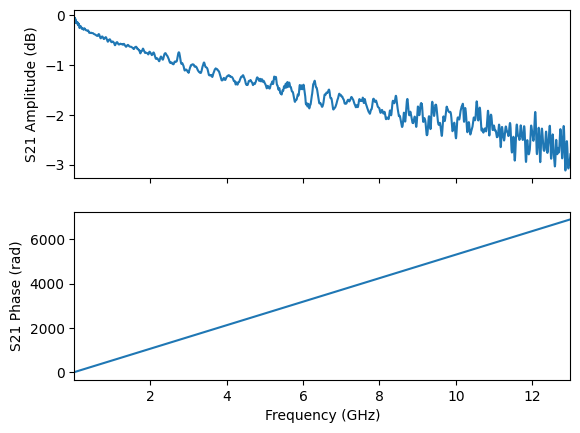

In [23]:
data = full_range_response(vna)

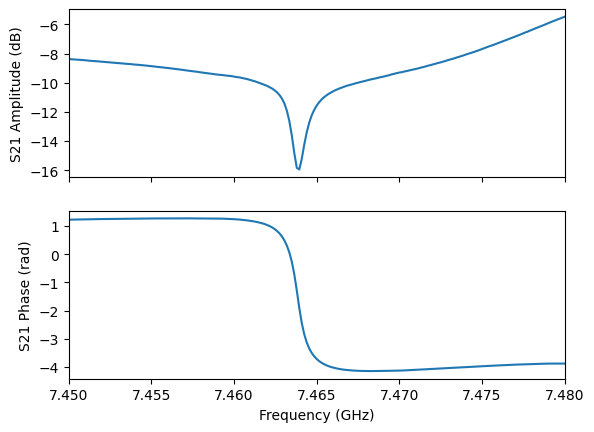

In [22]:
data = qubit_resonator(vna, qubit)

## Resonator Parameter Extraction

In [ ]:
# vna.format('PHAS')
# fig, data = vna_trace(vna, run=True)
# params, cov, chi = resonator_regression(data.index.to_numpy(), data['I'] + 1j*data['Q'])
# # rparams = hanger_resonator_params(*params, covar=cov)
# rparams = reflection_resonator_params(*params, covar=cov)
# smith = resonator_f_to_S(data.index.to_numpy(), *params)
# fig.axes[0].plot(data.index/1e9, 20*np.log10(np.abs(smith)), '--', color='gray')
# fig.axes[1].plot(data.index/1e9, np.angle(smith), '--', color='gray')
# # txt = f'$f = {rparams["f0"]/1e9:.3f}$ GHz, $\\kappa = {rparams["kappa"]/1e6:.2f}$ MHz, \n $\\ Qi = {rparams["Qi"]}$ '
# txt = f'$f = {rparams["f0"]/1e9:.3f}$ GHz, $\\kappa = {rparams["kappa"]/1e6:.2f}$ MHz '
# fig.axes[1].text(0.78, 0.6, txt, ha='right', transform=fig.axes[1].transAxes)
# print(rparams)

# Punchout

In [206]:
def punchout(vna, qubit):
    vna.two_tone_mode(two_tone_port=3, mode=False)
    vna.electrical_delay(92.0e-9)
    vna.points(201)
    vna.averages(1)
    vna.if_bandwidth(20)
    vna.start(7.4*1e9)
    vna.stop(7.5*1e9)

    sweeps = []

    punchout_powers = np.linspace(-80, -20, 7)
    for i, power in tqdm(enumerate(punchout_powers)):
        vna_port_source_power(vna, power)
        fig, data = vna_trace(vna, run=True)
        ax = fig.gca()
        ax.grid()
        sweeps.append(data) # assuming frequencies are fixed throughout the punchout sweep
        data = pd.concat(sweeps, keys=punchout_powers[:i+1], names=['power'])
    
    name = f'{device}_{qubit}_punchout_{int(vna.if_bandwidth())}IFBW_{int(vna.averages())}avg'
    non_redund_save_pd(data, name)
    return data, name

def punchout_plot(data, name):
    powers = data.index.levels[0]
    frequencies = data.index.levels[1]
    n_powers = len(powers)
    n_freq = len(frequencies)
    plotting_amplitude = data['amplitude'].to_numpy().reshape(n_powers, n_freq).transpose()
    plotting_phase = data['phase'].to_numpy().reshape(n_powers, n_freq).transpose()

    fig, ax = plt.subplots(1, 2, figsize=(10,6))
    cmesh_amp = ax[0].pcolormesh(powers, frequencies, plotting_amplitude)
    ax[0].set_xlabel('Power')
    ax[0].set_ylabel('Frequency')
    fig.colorbar(cmesh_amp, label='Amplitude')
    cmesh_phase = ax[1].pcolormesh(powers, frequencies, plotting_phase)
    ax[1].set_xlabel('Power')
    ax[1].set_ylabel('Frequency')
    fig.colorbar(cmesh_phase, label='Phase')
    fig.tight_layout(w_pad=2)
    non_redund_save_fig(fig, name)

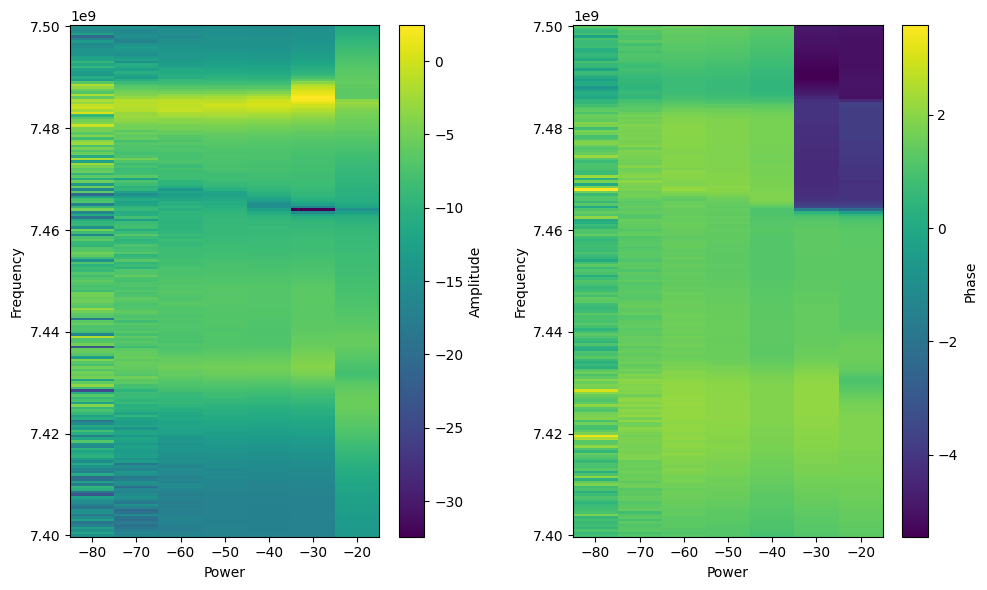

In [207]:
# name = ...
# data = pd.read_csv(name, index_col=[0, 1])
# data, name = punchout(vna, qubit)
punchout_plot(data, name)

# Flux Tuning

## Connect to Yoko

In [4]:
#ON_CHIP
try:
    yoko_onchip = GS200(name='yoko_onchip', address='TCPIP::192.168.4.157')
    yoko_onchip.source_mode('CURR')
except Exception as e:
    print(e)

yoko_onchip.current_limit(10e-3)
yoko_onchip.range(1e-3)
# yoko_onchip.ramp_current(0e-3, step=1e-4, delay=0.1)
yoko_onchip.on()

Connected to: YOKOGAWA GS210 (serial:91S621541, firmware:2.02) in 0.03s
('Cannot switch mode while source is on', 'setting yoko_onchip_source_mode to CURR')


In [5]:
#COIL
try:
    yoko_coil = GS200(name='yoko_coil', address='TCPIP::192.168.4.208')
    yoko_coil.source_mode('CURR')
except Exception as e:
    print(e)

yoko_coil.current_limit(10e-3)
yoko_coil.range(1e-3)
# yoko_coil.ramp_current(0e-3, step=1e-4, delay=0.1)
yoko_coil.on()


Connected to: YOKOGAWA GS210 (serial:91PC11413, firmware:2.02) in 0.03s
('Cannot switch mode while source is on', 'setting yoko_coil_source_mode to CURR')


## Single Flux Sweep

In [151]:
def single_flux_res_sweep(vna, yoko):
    vna_port_source_power(-60)
    vna.points(201)
    vna.averages(1)
    vna.if_bandwidth(200)
    vna.start(7.45e9)
    vna.stop(7.49e9)
    start_current = -0.5 #mA
    end_current = 0.5 #mA
    num_sweep = 101
    currents = np.linspace(start_current, end_current, num_sweep) * 1e-3
    sweeps = []
    for i, current in tqdm(enumerate(currents)):
        yoko.ramp_current(current, step=1e-5, delay=0.01)
        time.sleep(0.2)
        data = vna_trace_no_fig(vna, run=True)
        sweeps.append(data) # assuming frequencies are fixed throughout the punchout sweep
        data = pd.concat(sweeps, keys=currents[:i+1], names=['current'])  
    
    name = f'{device}_{qubit}_{yoko.name}_{int(vna.if_bandwidth())}IFBW_{int(vna.averages())}avg'
    non_redund_save_pd(data, name)
    return data, name

def single_flux_res_sweep_plot(data, name):
    currents = data.index.levels[0]
    frequencies = data.index.levels[1]
    n_currents = len(currents)
    n_freq = len(frequencies)
    plotting_amplitude = data['amplitude'].to_numpy().reshape(n_currents, n_freq).transpose()
    plotting_phase = data['phase'].to_numpy().reshape(n_currents, n_freq).transpose()

    fig, ax = plt.subplots(1, 2, figsize=(10,6))
    cmesh_amp = ax[0].pcolormesh(currents, frequencies, plotting_amplitude)
    ax[0].set_xlabel('Current')
    ax[0].set_ylabel('Frequency')
    fig.colorbar(cmesh_amp, label='Amplitude')
    cmesh_phase = ax[1].pcolormesh(currents, frequencies, plotting_phase)
    ax[1].set_xlabel('Current')
    ax[1].set_ylabel('Frequency')
    fig.colorbar(cmesh_phase, label='Phase')

    non_redund_save_fig(fig, name)


In [ ]:
# name = ...
# data = pd.read_csv(name, index_col=[0, 1])
data, name = single_flux_res_sweep(vna, yoko_coil)
single_flux_res_sweep_plot(data, name)

## Dual Flux Sweep

In [ ]:
def dual_flux_sweep(vna, yoko1, yoko2):
    vna_port_source_power(-60)
    vna.points(1)
    vna.averages(1)
    vna.if_bandwidth(10)
    vna.start(7.47e9)
    vna.stop(7.47e9)
    currents1 = np.linspace(-500, 500, 201) * 1e-6
    currents2 = np.linspace(-500, 500, 201) * 1e-6
    sweeps = []
    for i, current1 in tqdm(enumerate(currents1)):
        for j, current2 in tqdm(enumerate(currents2)):
            yoko1.ramp_current(current1, step=1e-5, delay=0.01)
            yoko2.ramp_current(current2, step=1e-5, delay=0.01)
            time.sleep(0.2)
            data = vna_trace_no_fig(vna, run=True)
            sweeps.append(data) # assuming frequencies are fixed throughout the punchout sweep
            data = pd.concat(sweeps, keys=(currents1[:i+1], currents2[:j+1]), names=[f'{yoko1.name}', f'{yoko2.name}'])  

    name = f'{device}_{qubit}_{yoko1.name}_{int(vna.if_bandwidth())}IFBW_{int(vna.averages())}avg'
    non_redund_save_pd(data, name)
    return data, name

def dual_flux_sweep_plot(data, name):
    currents1 = data.index.levels[0]
    currents2 = data.index.levels[1]
    n_currents1 = len(currents1)
    n_currents2 = len(currents2)
    plotting_amplitude = data['amplitude'].to_numpy().reshape(n_currents1, n_currents2).transpose()
    plotting_phase = data['phase'].to_numpy().reshape(n_currents1, n_currents2).transpose()

    fig, ax = plt.subplots(1, 2, figsize=(10,6))
    cmesh_amp = ax[0].pcolormesh(currents1, currents2, plotting_amplitude)
    ax[0].set_xlabel(f'{currents1.name}')
    ax[0].set_ylabel(f'{currents2.name}')
    fig.colorbar(cmesh_amp, label='Amplitude')
    cmesh_phase = ax[1].pcolormesh(currents1, currents2, plotting_phase)
    ax[1].set_xlabel(f'{currents1.name}')
    ax[1].set_ylabel(f'{currents2.name}')
    fig.colorbar(cmesh_phase, label='Phase')

    non_redund_save_fig(fig, name)

In [ ]:
# name = ...
# data = pd.read_csv(name, index_col=[0, 1])
data, name = dual_flux_sweep(vna, yoko_coil, yoko_onchip)
dual_flux_sweep_plot(data, name)

# Two Tone

## Constant Flux

In [214]:
#initialize currents
yoko_onchip.current_limit(10e-3)
yoko_onchip.range(1e-3)
yoko_onchip.ramp_current(0e-3, step=1e-4, delay=0.1)
yoko_onchip.on()

yoko_coil.current_limit(10e-3)
yoko_coil.range(1e-3)
yoko_coil.ramp_current(0e-3, step=1e-4, delay=0.1)
yoko_coil.on()

In [6]:
def two_tone(vna, drive_power, vna_power):
    vna.two_tone_mode(two_tone_port=3, mode=False, frequency = 7298958000.0)
    vna_port_source_power(vna, vna_power)
    vna.start(7.462*1e9)
    vna.stop(7.474*1e9)
    vna.points(121)
    vna.averages(1)
    vna.if_bandwidth(5)

    fig, data = vna_trace(vna, run=True)
    params, cov, chi = resonator_regression(data.index.to_numpy(), data['I'] + 1j*data['Q'])
    rparams = reflection_resonator_params(*params, covar=cov)
    smith = resonator_f_to_S(data.index.to_numpy(), *params)
    fig.axes[0].plot(data.index/1e9, 20*np.log10(np.abs(smith)), '--', color='gray')
    fig.axes[1].plot(data.index/1e9, np.angle(smith), '--', color='gray')
    fig.axes[0].axvline(rparams['f0']/1e9)

    if rparams['f0_sd'] > 5e5:
        rfreq = min(data['amplitude'])
    else:
        rfreq = rparams['f0']

    vna.two_tone_mode(two_tone_port=3, mode=True, frequency = rfreq)
    vna_port_source_power(vna, vna_power)
    vna.if_bandwidth(10)
    vna.averages(1)
    vna.points(730*1+1)
    vna.start(0.01*1e9)
    vna.stop(7.31*1e9)
    vna.ports[2].source_power(drive_power)
    
    fig, data = vna_trace(vna, run=True)
    return data, rfreq

# data = two_tone(vna, 10, -60)

### Drive Power Test

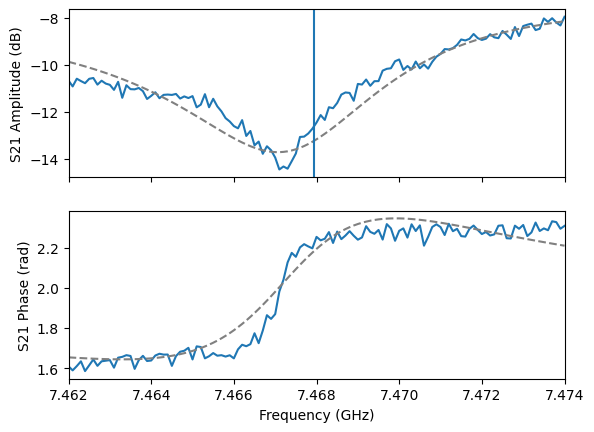

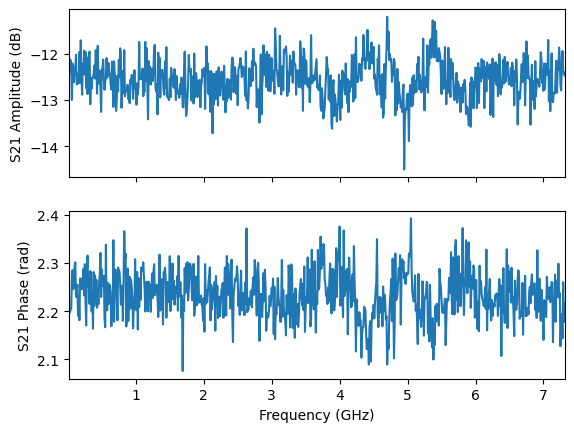

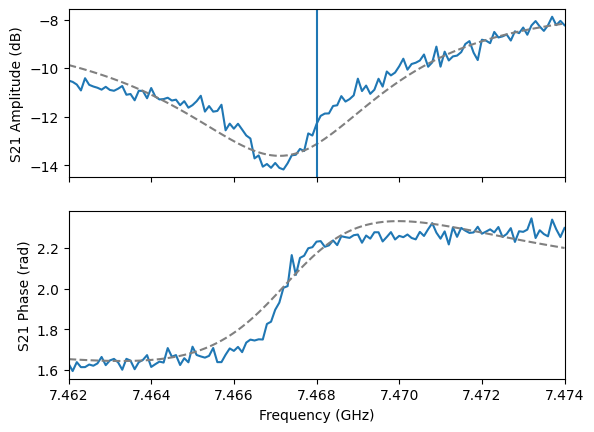

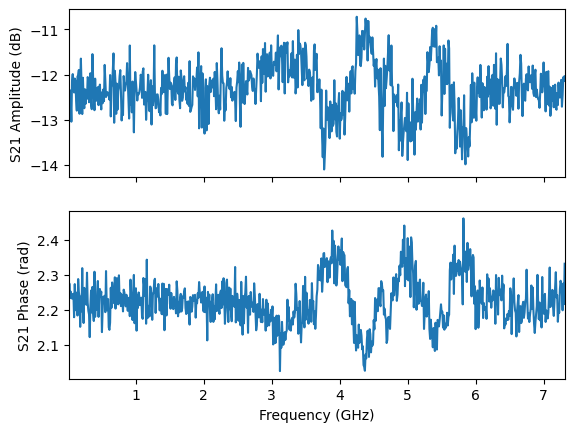

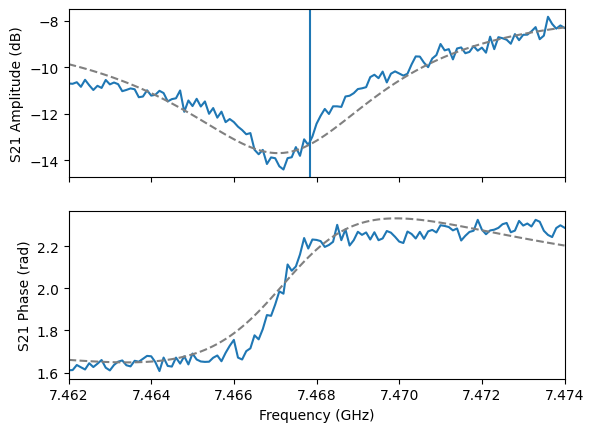

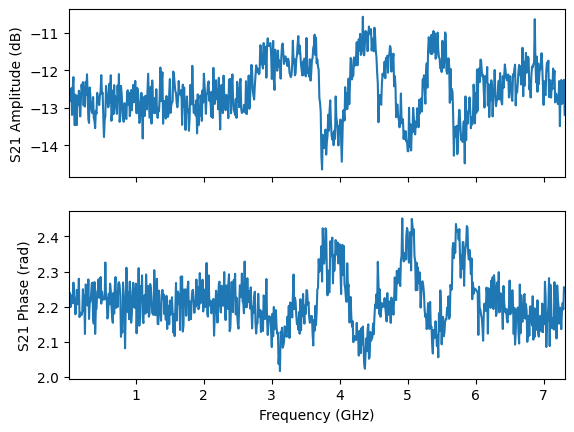

In [9]:
drive_powers = np.linspace(-10, 10, 3)
vna_power = -60
for drive_power in drive_powers:
    data = two_tone(vna, drive_power, vna_power)

### VNA Power Test

In [ ]:
vna_powers = np.linspace(-60, -50, 4)
drive_power = 5
for vna_power in vna_powers:
    fig, data = two_tone(vna, drive_power, vna_power)

## Flux Sweep Two Tone

In [19]:
# onchip_currents = np.linspace(212-980, 212, int(980/5) + 1) * 1e-6
onchip_currents = np.linspace(212, 222, 2) * 1e-6
coil_currents = (-16/980)*(onchip_currents-265.5e-6)+13.5e-6

def two_tone_flux_sweep(vna, coil_currents, onchip_currents):
    sweeps = []
    res = []
    for i, coil_current in tqdm(enumerate(coil_currents)):
        drive_power = 5
        vna_power = -60

        onchip_current = onchip_currents[i]
        print(f"Current is: onchip:{onchip_current}")
        print(f"Current is: coil:{coil_current}")
        yoko_onchip.ramp_current(onchip_current, step=1e-5, delay=0.1)
        yoko_coil.ramp_current(coil_current, step=1e-5, delay=0.1)
        time.sleep(2)

        try:
            swp, rfreq = two_tone(vna, drive_power, vna_power)
        except:
            try:
                print('Error')
                time.sleep(3)
                swp, rfreq = vna_trace_no_fig(vna, run=False)
            except:
                print(f'Still error on {i}')

        sweeps += [swp]
        res += [rfreq]


    name = f'{device}_{qubit}_two_tone_currents_sweep_drivepower{drive_power}'
    data = pd.concat(sweeps, keys=(onchip_current[:i+1],coil_current[:i+1]), names=['On-chip Current', 'Coil Current'])
    non_redund_save_pd(data, name)
    non_redund_save_csv(res, name + '_resfreq')
    
    return data, name, res

def two_tone_flux_sweep_plot(data, name):
    currents1 = data.index.levels[0]
    currents2 = data.index.levels[1]
    drive_freq = data.index.levels[2]

    plotting_currents = currents1

    plotting_amplitude = data['amplitude'].to_numpy().reshape(len(plotting_currents), len(drive_freq)).transpose()
    plotting_phase = data['phase'].to_numpy().reshape(len(plotting_currents), len(drive_freq)).transpose()

    normalized_amp_data = []
    for i, column in enumerate(plotting_amplitude):
        column = (column - np.mean(column))/np.std(column)
        normalized_amp_data.append(column)
    normalized_amp_data = np.asarray(normalized_amp_data).transpose()

    fig, ax = plt.subplots(1, 2, figsize=(10,6))
    cmesh_amp = ax[0].pcolormesh(plotting_currents, drive_freq, normalized_amp_data)
    ax[0].set_xlabel(f'{plotting_currents.name}')
    ax[0].set_ylabel('Drive Frequency')
    fig.colorbar(cmesh_amp, label='Amplitude')
    cmesh_phase = ax[1].pcolormesh(plotting_currents, drive_freq, plotting_phase)
    ax[1].set_xlabel(f'{plotting_currents.name}')
    ax[1].set_ylabel('Drive Frequency')
    fig.colorbar(cmesh_phase, label='Phase')

    non_redund_save_fig(fig, name)

In [ ]:
data, name, res = two_tone_flux_sweep(vna, coil_currents, onchip_currents)
two_tone_flux_sweep_plot(vna, name)

### Old Flux Sweep Two Tone (Definitely Works)

In [10]:
# onchip_currents = np.linspace(-492, 488, int(980/8) + 1) * 1e-6
onchip_currents = np.linspace(212-980, 212, int(980/5) + 1) * 1e-6
# onchip_currents = np.linspace(-492-55, -492+55, 111)*1e-6
coil_currents = (-16/980)*(onchip_currents-265.5e-6)+13.5e-6
# coil_currents = np.linspace(-200e-6, 200e-6, 101)
current_step = 1e-6

# yoko_coil.ramp_current(0e-3, step=1e-4, delay=0.1)
# yoko_onchip.ramp_current(0e-3, step=1e-4, delay=0.1)
yoko_coil.on()
yoko_onchip.on()

two_tone_start = 0.01*1e9
two_tone_end = 7.31*1e9
two_tone_power = 5 #with 20dB attenuation
two_tone_points = 730*1+1

sweeps = []
res = []

for i, coil_current in tqdm(enumerate(coil_currents)):
    # coil_current = coil_currents[i]
    onchip_current = onchip_currents[i]
    print(f"Current is: onchip:{onchip_current}")
    print(f"Current is: coil:{coil_current}")
    yoko_onchip.ramp_current(onchip_current, step=current_step, delay=0.1)
    yoko_coil.ramp_current(coil_current, step=current_step, delay=0.1)
    time.sleep(2)
    
    ### Fit resonator
    vna.two_tone_mode(two_tone_port=3, mode=False, frequency = 7298958000.0)
    vna.start(7.462*1e9)
    vna.stop(7.474*1e9)
    vna_port_source_power(vna, -60)
    vna.points(12*10+1)
    vna.averages(2)
    vna.if_bandwidth(5)
    fig, data = vna_trace(vna, run=True)
    
    # params, cov, chi = resonator_regression(data.index.to_numpy(), data['I'] + 1j*data['Q'])
    # rparams = reflection_resonator_params(*params, covar=cov)
    # smith = resonator_f_to_S(data.index.to_numpy(), *params)
    # fig.axes[0].plot(data.index/1e9, 20*np.log10(np.abs(smith)), '--', color='gray')
    # fig.axes[1].plot(data.index/1e9, np.angle(smith), '--', color='gray')
    # fig.axes[0].axvline(rparams['f0']/1e9)
    # res_freq = rparams['f0']/1e9

    res_freq = data['amplitude'].idxmin()
    print(f'Resonator frequency is: {res_freq} GHz')
    

    ### Perform Two Tone       
    vna.two_tone_mode(two_tone_port=3, mode=True, frequency = res_freq)
    vna.if_bandwidth(5)
    vna.points(two_tone_points)
    vna.start(two_tone_start)
    vna.stop(two_tone_end)
    vna.averages(1)
    vna.ports[2].source_power(two_tone_power)

    try:
        swp = vna_trace_no_fig(vna, run=True)
    except:
        try:
            print('Error')
            time.sleep(3)
            swp = vna_trace_no_fig(vna, run=False)
        except:
            print(f'Still error on {i}')

    sweeps += [swp]
    res += [res_freq]

name = str(date.today()) + f'_{device}_{qubit}_current_sweep_{two_tone_start}to{two_tone_end}GHz_{two_tone_power}dbm_avg1.csv'
data = pd.concat(sweeps, keys=coil_currents[:i+1], names=['Current'])
data.to_csv(datadir / name)

In [ ]:
#SAVE res list!
print(name)
display(data)
data.loc['Current'].set_index(res, append=True)
display(data)

In [151]:
# data = pd.read_csv(datadir / '2024-08-14_GKP_v0_soft_gkp_current_sweep_10000000.0to7310000000.0GHz_5dbm_avg1.csv', index_col=[0, 1])

In [ ]:
plotting_two_tone_data = np.array(data['amplitude'][:]).reshape((731, int(980/5) + 1)).transpose()
plotting_two_tone_data = (plotting_two_tone_data-np.mean(plotting_two_tone_data))/np.mean(plotting_two_tone_data)
plt.pcolormesh(plotting_two_tone_data, vmin=-1, vmax=1)

In [13]:
# data = two_tone_data
two_tone_plot = np.array(data['amplitude'][:]).reshape((197,731)).transpose()
normalized_data = []
for i, column in enumerate(two_tone_plot.transpose()):
    column = (column - np.mean(column))/np.std(column)
    normalized_data.append(column)
# normalized_data = np.subtract(two_tone_plot-mean_vals, axis=1)/std_vals
normalized_data = np.asarray(normalized_data).transpose()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
normalized_abs_data = np.abs(normalized_data)
im = ax.pcolormesh(onchip_currents, np.linspace(two_tone_start, two_tone_end, 731), normalized_data, cmap='seismic',
                  vmin=-6, vmax=6)
ax.set_xlabel('Current')
ax.set_ylabel('Frequency')
fig.colorbar(im)

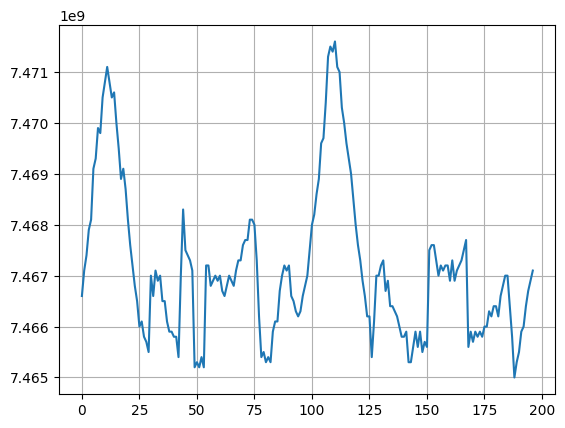

In [18]:
plt.plot(res)
plt.grid()